# Trend Following Returns Estimator

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Getting the data

In [2]:
fut_path = r"C:\Users\Diego\Documents\GitHub\TrendConvexity\data\FuturesData.parquet"

In [3]:
df_px  = (pd.read_parquet(
    path = fut_path, engine = "pyarrow").
    assign(security = lambda x: x.security.str.split(" ").str[0]).
    rename(columns = {"PX_LAST": "px"}).
    set_index("date").
    drop_duplicates())

In [4]:
def _generate_trend_and_vol(df: pd.DataFrame,window: int = 180) -> pd.DataFrame: 

    df_prep = (df.sort_index().assign(
        dt            = lambda x: x.px.diff() / x.px.diff().ewm(span = 10, adjust = False).std(),
        rtn           = lambda x: x.px.pct_change(),
        trend_signal  = lambda x: (x.dt.ewm(span = window, adjust = False).mean()).shift(),
        trend_rtn     = lambda x: np.sign(x.trend_signal) * x.rtn,
        trend_rsk_rtn = lambda x: x.trend_rtn * (0.1 / (x.trend_rtn.ewm(span = 100, adjust = False).std()* np.sqrt(252))),
        cuml_trend    = lambda x: x.trend_rsk_rtn.rolling(window // 2).sum(),
        vol_signal    = lambda x: (window * x.trend_signal.pow(2) - (x.dt.pow(2)).ewm(span=window // 2, adjust=False).mean())))
    
    return df_prep

window  = 180
df_prep = (df_px.groupby(
    "security").
    apply(_generate_trend_and_vol, window).
    drop(columns = ["security"]).
    reset_index())

renamer = {
        "trend_rsk_rtn": "TF Returns",
        "vol_rsk_rtn"  : "Vol Returns"}

# Comparing cumulative trend following returns vs difference in long term and short term volatility

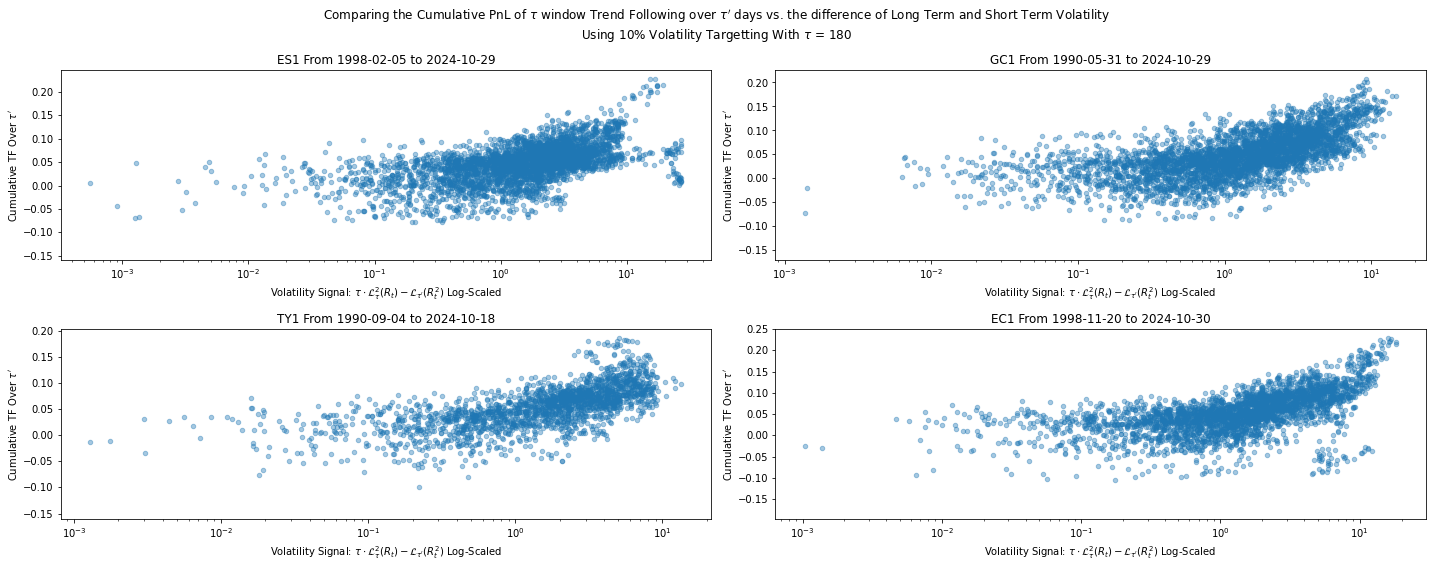

In [5]:
securities = ["ES1", "GC1", "TY1", "EC1"]
fig, axes  = plt.subplots(ncols = 2, nrows = 2, figsize = (20,8))

for security, ax in zip(securities, axes.flatten()): 

    df_plot = (df_prep.query(
        "security == @security").
        dropna())
    
    (df_plot.plot(
        ax     = ax, 
        kind   = "scatter", 
        x      = "vol_signal", 
        y      = "cuml_trend", 
        alpha  = 0.4,
        logx   = True,
        xlabel = "Volatility Signal: " + r"$\tau \cdot \mathcal{L}_{\tau}^2(R_t) - \mathcal{L}_{\tau'}(R_t^2)$ Log-Scaled",
        ylabel = "Cumulative TF Over " + r"$\tau'$",
        title  = "{} From {} to {}".format(
            security,
            df_plot.date.min().date(),
            df_plot.date.max().date())))
    
fig.suptitle(
    r"Comparing the Cumulative PnL of $\tau$ window Trend Following over $\tau'$ days vs. the difference of Long Term and Short Term Volatility" + 
    "\nUsing 10% Volatility Targetting" + r" With $\tau$ = 180")
plt.tight_layout()

In [6]:
def _get_ols(df: pd.DataFrame) -> pd.DataFrame: 
    
    model = (sm.OLS(
        endog = df.cuml_trend,
        exog  = sm.add_constant(df.vol_signal)).
        fit())
    
    df_param  = model.params.to_frame(name = "param_val").reset_index()
    df_pvalue = model.pvalues.to_frame(name = "p_value").reset_index()
    df_tstat  = model.tvalues.to_frame(name = "t_value").reset_index()
    
    df_out = (df_param.merge(
        right = df_pvalue, how = "inner", on = ["index"]).
        merge(right = df_tstat, how = "inner", on = ["index"]))
    
    return df_out
    
df_ols = (df_prep.assign(
    vol_signal = lambda x: np.log(x.vol_signal)).
    dropna().
    groupby("security").
    apply(_get_ols).
    reset_index().
    drop(columns = ["level_1"]).
    rename(columns = {"index": "param"}))

C:\Users\Diego\anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
df_sharpe_compare = (df_prep[
    ["date", "security", "rtn", "trend_rsk_rtn"]].
    dropna().
    melt(id_vars = ["date", "security"]).
    drop(columns = ["date"]).
    groupby(["security", "variable"]).
    agg(lambda x: x.mean() / x.std() * np.sqrt(252)).
    reset_index().
    pivot(index = "security", columns = "variable", values = "value").
    assign(sharpe_spread = lambda x: x.trend_rsk_rtn - x.rtn))

In [8]:
df_combined = (df_ols.merge(
    right = df_sharpe_compare, how = "inner", on = ["security"]))

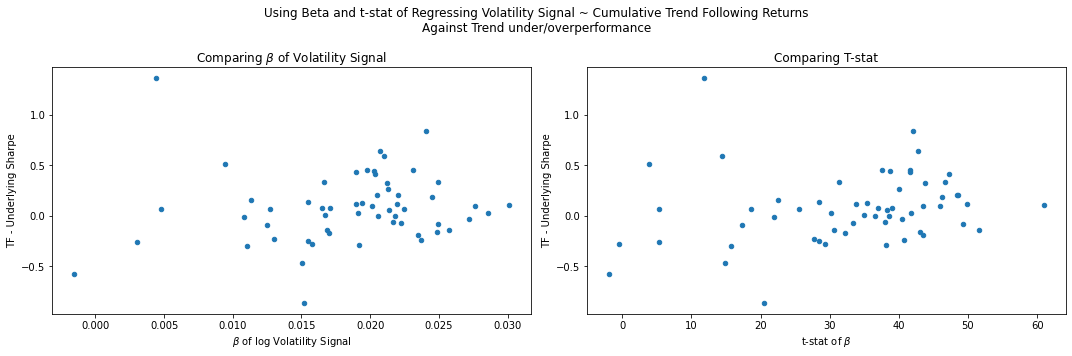

In [9]:
fig, axes = plt.subplots(ncols = 2, figsize = (15,5))

(df_combined.query(
    "param == 'vol_signal'").
    query("param_val >= -0.3").
    plot(
        kind   = "scatter",
        x      = "param_val",
        y      = "sharpe_spread",
        ax     = axes[0],
        xlabel = r"$\beta$ of log Volatility Signal",
        ylabel = "TF - Underlying Sharpe",
        title  = r"Comparing $\beta$ of Volatility Signal"))

(df_combined.query(
    "param == 'vol_signal'").
    plot(
        kind   = "scatter",
        x      = "t_value",
        y      = "sharpe_spread",
        ax     = axes[1],
        ylabel = "TF - Underlying Sharpe",
        xlabel = r"t-stat of $\beta$",
        title  = "Comparing T-stat"))

fig.suptitle("Using Beta and t-stat of Regressing Volatility Signal ~ Cumulative Trend Following Returns\nAgainst Trend under/overperformance")
plt.tight_layout()